File: detect_touch_square.ipynb  
Author: Luciano Orlandini  
Created: March, 2022  
  
Description:  
File includes data analysis and training of Machine Learning algorithm  
to detect user touch on the Gadget Board with square accuracy.  
  
Accuracy:  
Square - Detects if touch is on one of the 36 squares (2 x 2 LEDs).

Load dataset file as Pandas dataframe and display head.

In [1]:
import pandas as pd

# Load and shuffle database
path = 'data_handler/data/'
data = pd.read_csv(path + 'simon_square.csv')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
print(data.head())
print('Original Shape: ', data.shape)

# Remove outliers
for i in range (0, 144):
    indexes = data[ (data[str(i)] < 450) | (data[str(i)] > 650) ].index
    data.drop(indexes, inplace=True)
data.reset_index(drop=True, inplace=True)
print('Filtered Shape: ', data.shape)

     0    1    2    3    4    5    6    7    8    9  ...  135  136  137  138  \
0  555  563  555  552  552  554  551  555  614  627  ...  560  566  572  577   
1  560  568  557  558  556  559  557  566  563  562  ...  574  564  550  546   
2  542  551  542  542  540  542  540  550  548  546  ...  534  567  582  544   
3  571  580  572  572  574  576  571  577  578  586  ...  556  562  561  565   
4  540  549  539  537  537  544  538  545  542  542  ...  546  548  551  619   

   139  140  141  142  143  144  
0  569  569  569  559  564    5  
1  543  552  565  615  646   36  
2  533  536  536  530  533   33  
3  560  558  557  551  555   21  
4  608  550  546  542  548   34  

[5 rows x 145 columns]
Original Shape:  (13918, 145)
Filtered Shape:  (11790, 145)


Separate dataframe in input ***X*** and output ***y***.  
Every row in ***X*** will have a corresponding output on the same row  
in ***y***.
Additionaly, data is sclaed to work in LogisticRegression classifier.

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X = data.iloc[:,:-1]
y = data['144']
unique_outputs = set(y)
n_unique_outputs = len(unique_outputs)

scaler = MinMaxScaler()
X = scaler.fit_transform(X.values, y.values)

min_max = open("min_max_square.txt", "w")
np.savetxt(min_max, scaler.data_min_)
np.savetxt(min_max, scaler.data_max_)
min_max.close()

X = X.astype(dtype='float32')
y = y.to_numpy(dtype='float32')

Plot histrogram of ***y*** to show distribution of quantities for each  
different output.

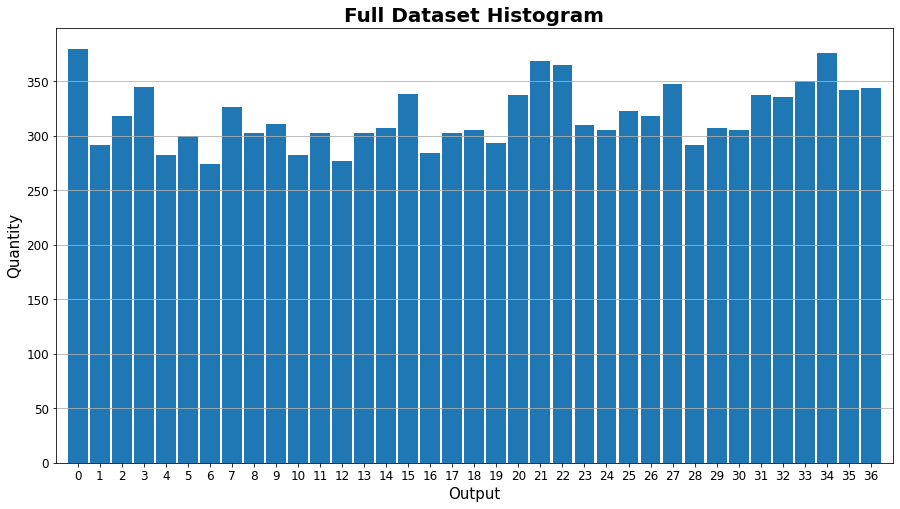

In [3]:
import matplotlib .pyplot as plt

plt.figure(figsize=(15,8))
plt.hist(data['144'], bins=np.arange(n_unique_outputs+1)-0.5, rwidth=0.9)
plt.title('Full Dataset Histogram', fontsize=20, fontweight='bold')
plt.xlabel('Output', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.xticks(range(n_unique_outputs), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-1, n_unique_outputs)
plt.grid(axis='y')
plt.show()

Split data into train and test data.

In [4]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [    0     1     2 ... 11787 11788 11789] TEST: [    9    19    22 ... 11769 11776 11781]
TRAIN: [    0     3     5 ... 11786 11787 11788] TEST: [    1     2     4 ... 11772 11783 11789]
TRAIN: [    1     2     4 ... 11783 11788 11789] TEST: [    0     3     5 ... 11785 11786 11787]
TRAIN: [    0     1     2 ... 11786 11787 11789] TEST: [   14    21    27 ... 11773 11777 11788]


Create neural network using TensorFlow's Keras Sequential model.

In [5]:
# Disable TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

neural_net = tf.keras.Sequential()

neural_net.add(tf.keras.Input(shape=(144,)))
neural_net.add(tf.keras.layers.Dense(128, activation='relu'))
#neural_net.add(tf.keras.layers.Dropout(0.1))
neural_net.add(tf.keras.layers.Dense(37, activation='softmax'))

neural_net.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

neural_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               18560     
                                                                 
 dense_1 (Dense)             (None, 37)                4773      
                                                                 
Total params: 23,333
Trainable params: 23,333
Non-trainable params: 0
_________________________________________________________________


Fit model.

In [6]:
EPOCHS = 15

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = neural_net.fit(
    X[train_index],
    y[train_index],
    epochs=EPOCHS,
    batch_size=1,
    validation_data=(X[test_index], y[test_index]),
    callbacks=[model_checkpoint_callback]
)

neural_net.load_weights(checkpoint_filepath)

Epoch 1/15
8843/8843 [==============================] - 12s 1ms/step - loss: 3.4627 - accuracy: 0.0800 - val_loss: 3.1990 - val_accuracy: 0.1622
Epoch 2/15
8843/8843 [==============================] - 14s 2ms/step - loss: 2.9429 - accuracy: 0.2473 - val_loss: 2.6503 - val_accuracy: 0.3454
Epoch 3/15
8843/8843 [==============================] - 14s 2ms/step - loss: 2.3546 - accuracy: 0.4181 - val_loss: 2.0930 - val_accuracy: 0.4601
Epoch 4/15
8843/8843 [==============================] - 12s 1ms/step - loss: 1.8313 - accuracy: 0.5771 - val_loss: 1.5762 - val_accuracy: 0.6746
Epoch 5/15
8843/8843 [==============================] - 13s 1ms/step - loss: 1.4166 - accuracy: 0.7073 - val_loss: 1.2099 - val_accuracy: 0.7842
Epoch 6/15
8843/8843 [==============================] - 15s 2ms/step - loss: 1.0873 - accuracy: 0.7993 - val_loss: 0.9827 - val_accuracy: 0.7906
Epoch 7/15
8843/8843 [==============================] - 17s 2ms/step - loss: 0.8329 - accuracy: 0.8646 - val_loss: 0.7281 - val_ac

Plot metrics.

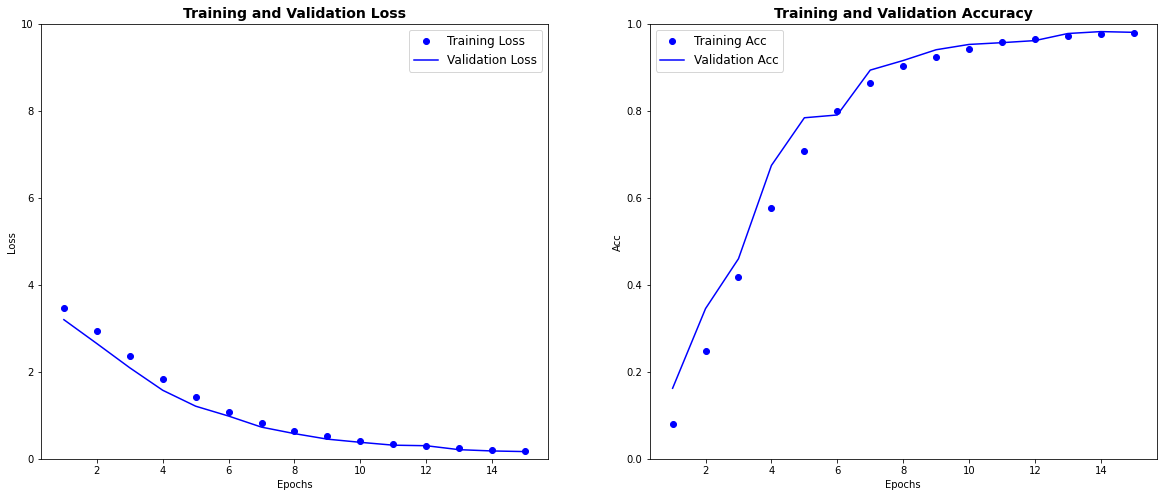

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) +1)

plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.legend(fontsize=12)
plt.ylim(0, 10)

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(fontsize=12)
plt.ylim(0, 1)

plt.show()

Print results.

93/93 [==============================] - 0s 2ms/step - loss: 0.1804 - accuracy: 0.9824
[0.1803702712059021, 0.9823549389839172]


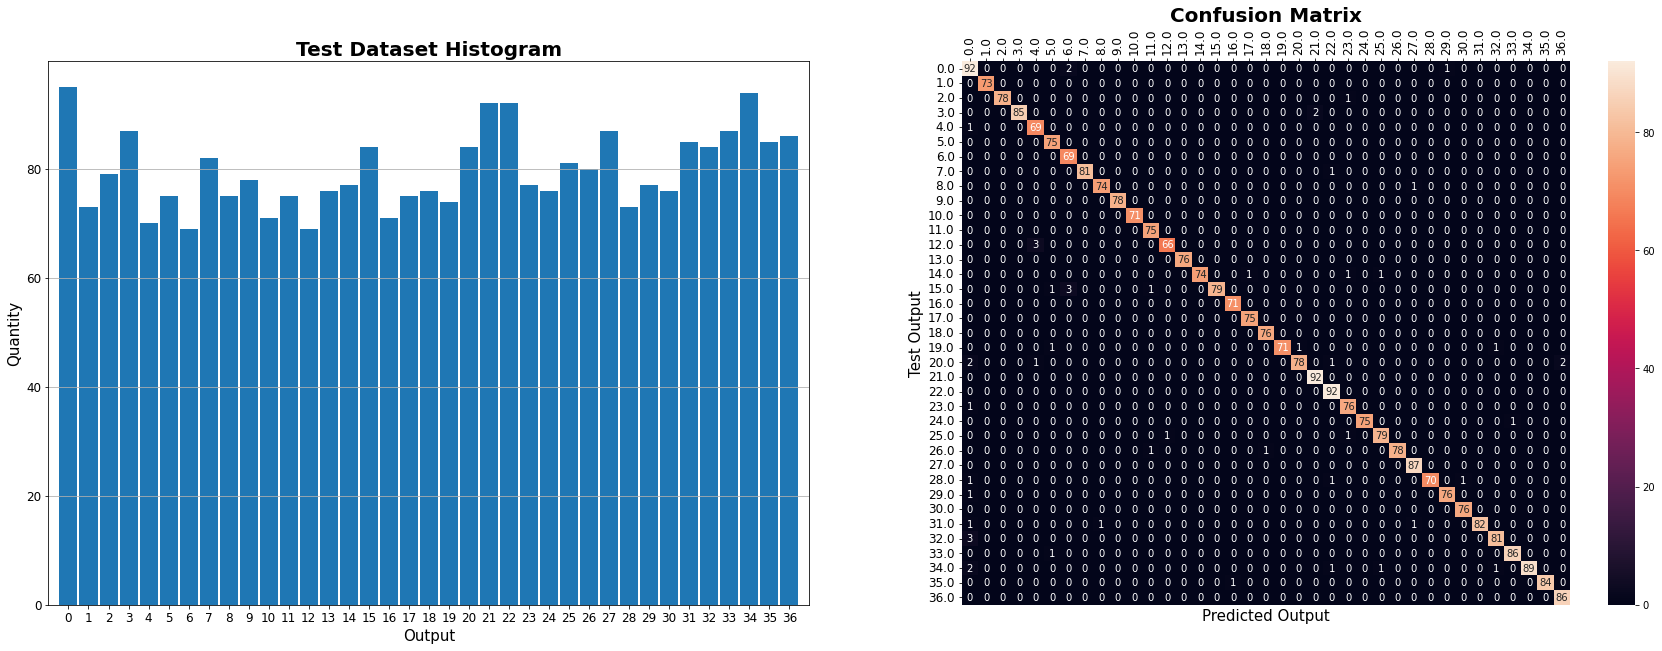

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

results = neural_net.evaluate(X[test_index], y[test_index])
print(results)

predictions = neural_net.predict(X[test_index])
y_pred = []
for i in range (0, predictions.shape[0]):
    y_pred.append(np.argmax(predictions[i]))

test_output = np.array(y[test_index])
pred_output = np.array(y_pred)
outputs, n_outputs = np.unique(test_output, return_counts=True)
length = len(outputs)

# Test dataset histogram
plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
plt.hist(test_output, bins=np.arange(length + 1) - 0.5, rwidth=0.9)
plt.title('Test Dataset Histogram', fontsize=20, fontweight='bold')
plt.xlabel('Output', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.xticks(range(length), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.xlim(-1, length)

# Confusion matrix
cm = confusion_matrix(test_output, pred_output)
cm_df = pd.DataFrame(cm, index=outputs, columns=outputs)
ax = plt.subplot(1, 2, 2)
ax.tick_params(top=True, bottom=False)
ax.tick_params(labeltop=True, labelbottom=False)
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.xlabel('Predicted Output', fontsize=15)
plt.ylabel('Test Output', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Save and export model.

In [9]:
neural_net.save('nn_square')

converter = tf.lite.TFLiteConverter.from_saved_model('nn_square')
tflite_model = converter.convert()

with open('nn_square.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: nn_square/assets
